In [2]:
import pandas as pd
import numpy as np
import datetime

import warnings
warnings.filterwarnings('ignore')


# Compute meme vs non-meme binary period

# Filter and join to financial data

# Add a regression model

# Add option to aggregate at weekly level

In [22]:
stocks = ['amc', 'bb', 'clov', 'wish', 'pltr', 'tsla', 'amzn', 'nok', 'meta', 'fb']

In [21]:
# Set all parameters here
comments = pd.read_csv('comments_preprocessed_assigned.csv')
fin_data = pd.read_csv('AMC_2021.csv')

In [4]:
comments['ticker'].value_counts()

amc     235141
bb      195023
clov    130118
wish     63366
pltr     57975
tsla     51815
amzn     44102
nok      27400
meta      3241
fb        2008
Name: ticker, dtype: int64

In [5]:
# Drop NA from comments
comments = comments[~comments['created_utc'].isna()]

## Create Daily Count of Comments For Each Ticker

In [46]:
# Grab only the ticker assignment and the date

comment_vol_df = comments[['created_utc', 'ticker']]
comment_vol_df['created_utc'] = pd.to_numeric(comment_vol_df['created_utc'], errors = 'coerce')

# Remove NAs created by the coerce
comment_vol_df = comment_vol_df[~comment_vol_df['created_utc'].isna()]
comment_vol_df['created_utc'] = comment_vol_df['created_utc'].astype(int)

comment_vol_df.head()

,created_utc,ticker
0,1612139703,amc
1,1611968923,amc
2,1611895308,amc
3,1611891585,amc
4,1611889728,amc


In [47]:
comment_vol_df['created_utc'] = pd.to_datetime(comment_vol_df['created_utc'],unit= 's')
comment_vol_df.head()

,created_utc,ticker
0,2021-02-01 00:35:03,amc
1,2021-01-30 01:08:43,amc
2,2021-01-29 04:41:48,amc
3,2021-01-29 03:39:45,amc
4,2021-01-29 03:08:48,amc


In [48]:
comment_vol_df['date'] = comment_vol_df['created_utc'].dt.date
comment_vol_df['date'] = pd.DatetimeIndex(comment_vol_df['date'])
comment_vol_df.head()

,created_utc,ticker,date
0,2021-02-01 00:35:03,amc,2021-02-01
1,2021-01-30 01:08:43,amc,2021-01-30
2,2021-01-29 04:41:48,amc,2021-01-29
3,2021-01-29 03:39:45,amc,2021-01-29
4,2021-01-29 03:08:48,amc,2021-01-29


In [50]:
# Create a binary column for stock
for stock in stocks:
    comment_vol_df[stock] = np.where(comment_vol_df['ticker'] == stock, 1, 0)

In [51]:
aggregations = {}
for stock in stocks:
    aggregations[stock] = np.sum

print(aggregations)

{'amc': <function sum at 0x108e77940>, 'bb': <function sum at 0x108e77940>, 'clov': <function sum at 0x108e77940>, 'wish': <function sum at 0x108e77940>, 'pltr': <function sum at 0x108e77940>, 'tsla': <function sum at 0x108e77940>, 'amzn': <function sum at 0x108e77940>, 'nok': <function sum at 0x108e77940>, 'meta': <function sum at 0x108e77940>, 'fb': <function sum at 0x108e77940>}


In [52]:
comment_vol_grouped = comment_vol_df.groupby(['date']).agg(aggregations).reset_index().sort_values(['date'])
comment_vol_grouped.head()

,date,amc,bb,clov,wish,pltr,tsla,amzn,nok,meta,fb
0,1970-01-01,3,0,0,0,0,0,0,0,0,0
1,2021-01-01,42,3,0,1,370,2,3,0,0,0
2,2021-01-02,8,3,0,1,31,303,4,0,1,1
3,2021-01-03,4,3,0,0,482,173,5,0,0,2
4,2021-01-04,0,0,0,0,320,161,7,0,0,0


In [53]:
# Only one line of weird values, drop
comment_vol_grouped[comment_vol_grouped['date'] < pd.Timestamp('2021-01-01')]

,date,amc,bb,clov,wish,pltr,tsla,amzn,nok,meta,fb
0,1970-01-01,3,0,0,0,0,0,0,0,0,0


In [54]:
comment_vol_grouped=comment_vol_grouped[~(comment_vol_grouped['date'] < pd.Timestamp('2021-01-01'))]
print(len(comment_vol_grouped))
comment_vol_grouped.head()

390


,date,amc,bb,clov,wish,pltr,tsla,amzn,nok,meta,fb
1,2021-01-01,42,3,0,1,370,2,3,0,0,0
2,2021-01-02,8,3,0,1,31,303,4,0,1,1
3,2021-01-03,4,3,0,0,482,173,5,0,0,2
4,2021-01-04,0,0,0,0,320,161,7,0,0,0
5,2021-01-05,0,1,0,1,122,190,5,0,0,0


## Join Comment Volume to Date

In [61]:
# Build an empty df with date only
start_date = '2021-01-01'
end_date = '2022-01-01'

# Generate a list of month-end closes
start = datetime.datetime.strptime(start_date, "%Y-%m-%d")
end = datetime.datetime.strptime(end_date, "%Y-%m-%d")
date_generated = pd.date_range(start, end, freq='D')

# Format date columns 
df = pd.DataFrame(date_generated)
df.columns = ['date'] # rename column

df.head()

,date
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05


In [62]:
# Inner join to Date Range
df = df.merge(comment_vol_grouped, how = 'left', on = 'date')
print('Length of DataFrame: {}'.format(len(df)))
df.head()

Length of DataFrame: 366


,date,amc,bb,clov,wish,pltr,tsla,amzn,nok,meta,fb
0,2021-01-01,42.0,3.0,0.0,1.0,370.0,2.0,3.0,0.0,0.0,0.0
1,2021-01-02,8.0,3.0,0.0,1.0,31.0,303.0,4.0,0.0,1.0,1.0
2,2021-01-03,4.0,3.0,0.0,0.0,482.0,173.0,5.0,0.0,0.0,2.0
3,2021-01-04,0.0,0.0,0.0,0.0,320.0,161.0,7.0,0.0,0.0,0.0
4,2021-01-05,0.0,1.0,0.0,1.0,122.0,190.0,5.0,0.0,0.0,0.0


In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

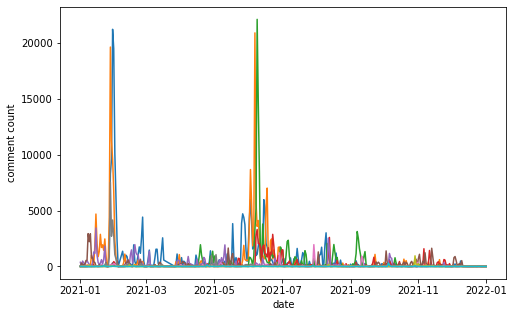

In [76]:
fig, ax = plt.subplots(figsize = (8,5))

for stock in stocks:
    sns.lineplot(x = 'date', y = stock, data = df, legend='auto')

plt.ylabel('comment count')
plt.show()

## Calculate Meme Period by Stock

- Get Weekly Average Comment Volume
- Get 4 Week Moving Average (over a month)
- Weekly more than 3x greater than 4 week MA  = MEME
- Weekly goes back 

Check the trend with Seaborn (viz the comment volume vs meme period)